Found image: https://live.staticflickr.com/65535/53112820204_a1015c4e02_m.jpg


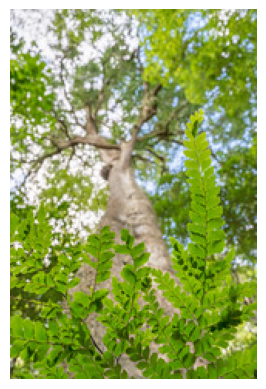

In [9]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import ollama

# --- 1. HELPER: GET IMAGE ---
def get_and_show_plant_image(scientific_name):
    """Downloads an image, shows it, and RETURNS the data for AI to use."""
    
    # Flickr Open API
    url = "https://www.flickr.com/services/feeds/photos_public.gne"
    params = {
        "format": "json",
        "nojsoncallback": 1,
        "tags": scientific_name.replace(" ", "_")
    }

    try:
        resp = requests.get(url, params=params, timeout=10)
        data = resp.json()
    except:
        print("Failed to load image feed.")
        return None

    items = data.get("items", [])
    if not items:
        print("No images found for:", scientific_name)
        return None

    image_url = items[0]["media"]["m"]
    print("Found image:", image_url)

    # Download the image
    img_resp = requests.get(image_url)
    img_data = img_resp.content # This is the raw bytes
    
    # Display it for you to see
    img = Image.open(BytesIO(img_data))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    return img_data

plant_name = "Adiantum trapeziforme" 

# Step A: Get the image AND save the data to a variable
img_data = get_and_show_plant_image(plant_name)

In [8]:
# Test with first 50 plants - Always get an image

def get_wikipedia_data_with_image(scientific_name: str) -> Optional[Dict]:
    """
    Fetch Wikipedia data, ensuring we always get an image.
    Falls back to genus if species doesn't have a thumbnail.
    """
    base_url = "https://en.wikipedia.org/api/rest_v1/page/summary/"
    headers = {
        'User-Agent': 'PlantGameBot/1.0 (Educational Project)',
        'Accept': 'application/json'
    }
    
    try:
        # Try full scientific name first
        encoded_name = requests.utils.quote(scientific_name)
        response = requests.get(f"{base_url}{encoded_name}", headers=headers, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            result = {
                'title': data.get('title', ''),
                'extract': data.get('extract', ''),
                'url': data.get('content_urls', {}).get('desktop', {}).get('page', ''),
                'thumbnail': data.get('thumbnail', {}).get('source', '') if 'thumbnail' in data else '',
                'description': data.get('description', ''),
                'source': 'species'
            }
            
            # If we got data but no image, try genus
            if result['title'] and not result['thumbnail']:
                genus = scientific_name.split()[0] if scientific_name.split() else scientific_name
                if genus != scientific_name:
                    print(f" (no image, trying genus: {genus})", end='')
                    genus_response = requests.get(f"{base_url}{requests.utils.quote(genus)}", headers=headers, timeout=10)
                    if genus_response.status_code == 200:
                        genus_data = genus_response.json()
                        if 'thumbnail' in genus_data:
                            result['thumbnail'] = genus_data['thumbnail']['source']
                            result['source'] = 'genus_image'
            
            return result
        
        # If species not found, try genus
        elif response.status_code == 404:
            genus = scientific_name.split()[0] if scientific_name.split() else scientific_name
            if genus != scientific_name:
                print(f" (trying genus: {genus})", end='')
                genus_response = requests.get(f"{base_url}{requests.utils.quote(genus)}", headers=headers, timeout=10)
                if genus_response.status_code == 200:
                    genus_data = genus_response.json()
                    return {
                        'title': genus_data.get('title', ''),
                        'extract': genus_data.get('extract', ''),
                        'url': genus_data.get('content_urls', {}).get('desktop', {}).get('page', ''),
                        'thumbnail': genus_data.get('thumbnail', {}).get('source', '') if 'thumbnail' in genus_data else '',
                        'description': genus_data.get('description', ''),
                        'source': 'genus'
                    }
        
        return None
            
    except Exception as e:
        print(f" Error: {str(e)}", end='')
        return None

def fetch_50_test(plant_names):
    """Quick test with first 50 plants"""
    results = []
    test_names = plant_names[:50]
    
    for i, name in enumerate(test_names):
        cleaned = clean_scientific_name(name)
        print(f"[{i+1}/50] {cleaned}", end='')
        
        wiki_data = get_wikipedia_data_with_image(cleaned)
        
        if wiki_data:
            results.append({
                'original_name': name,
                'cleaned_name': cleaned,
                'title': wiki_data['title'],
                'extract': wiki_data['extract'][:200] + '...' if len(wiki_data['extract']) > 200 else wiki_data['extract'],
                'url': wiki_data['url'],
                'thumbnail': wiki_data['thumbnail'],
                'description': wiki_data['description'],
                'source': wiki_data['source'],
                'has_image': bool(wiki_data['thumbnail']),
                'found': True
            })
            img_status = "🖼️" if wiki_data['thumbnail'] else "❌"
            print(f" ✓ {img_status}")
        else:
            results.append({
                'original_name': name,
                'cleaned_name': cleaned,
                'title': '', 'extract': '', 'url': '', 'thumbnail': '', 'description': '',
                'source': 'not_found', 'has_image': False, 'found': False
            })
            print(" ✗")
        
        time.sleep(0.3)
    
    return pd.DataFrame(results)

# Run test
print("Testing with first 50 plants...\n")
test_df = fetch_50_test(plant_names)

# Summary
print(f"\n{'='*60}")
print(f"RESULTS:")
print(f"  Found: {test_df['found'].sum()}/50")
print(f"  With images: {test_df['has_image'].sum()}/50")
print(f"  Success rate: {test_df['found'].sum()/50*100:.1f}%")
print(f"  Image rate: {test_df['has_image'].sum()/50*100:.1f}%")
print(f"{'='*60}")

# Show image sources
print("\nImage sources:")
print(test_df['source'].value_counts())

# Show some examples with images
print("\n=== Examples with images ===")
with_images = test_df[test_df['has_image']]
for idx, row in with_images.head(5).iterrows():
    print(f"\n{row['original_name']}:")
    print(f"  Title: {row['title']}")
    print(f"  Image: {row['thumbnail'][:80]}...")
    print(f"  Source: {row['source']}")


Testing with first 50 plants...

[1/50] Adiantum peruvianum ✓ 🖼️
[2/50] Adiantum raddianum ✓ 🖼️
[3/50] Adiantum ternerum (trying genus: Adiantum) ✓ 🖼️
[4/50] Adiantum trapeziforme ✓ 🖼️
[5/50] Aechmea ✓ 🖼️
[6/50] Aechmea ✓ 🖼️
[7/50] Aechmea ✓ 🖼️
[8/50] Aechmea ✓ 🖼️
[9/50] Aechmea ✓ 🖼️
[10/50] Aechmea ✓ 🖼️
[11/50] Aechmea blanchetiana ✓ 🖼️
[12/50] Aechmea chantinii ✓ 🖼️
[13/50] Aechmea fasciata ✓ 🖼️
[14/50] Aechmea fulgens ✓ 🖼️
[15/50] Aechmea gamosepala ✓ 🖼️
[16/50] Aechmea gamosepala ✓ 🖼️
[17/50] Aechmea miniata ✓ 🖼️
[18/50] Alocasia baginda ✓ 🖼️
[19/50] Alocasia baginda ✓ 🖼️
[20/50] Alocasia heterophylla ✓ 🖼️
[21/50] Alocasia reginula ✓ 🖼️
[22/50] Alocasia zebrina ✓ 🖼️
[23/50] Alpinia vittata (trying genus: Alpinia) ✓ 🖼️
[24/50] Amorphophallus bulbifer ✓ 🖼️
[25/50] Amorphophallus konjac ✓ 🖼️
[26/50] Amorphophallus titanum ✓ 🖼️
[27/50] Anthurium ✓ 🖼️
[28/50] Anthurium andraeanum ✓ 🖼️
[29/50] Anthurium atropurpureum (trying genus: Anthurium) ✓ 🖼️
[30/50] Anthurium atropurpureum (trying 

In [9]:
# Display first 10 images from Wikipedia results

from IPython.display import display, Image, HTML
import requests
from io import BytesIO

# Get plants with images
plants_with_images = test_df[test_df['has_image']].head(10)

print(f"Displaying {len(plants_with_images)} plant images:\n")

for idx, row in plants_with_images.iterrows():
    # Create HTML for better formatting
    html = f"""
    <div style="margin-bottom: 30px; border: 2px solid #ddd; padding: 15px; border-radius: 10px;">
        <h3 style="color: #2c5f2d; margin-top: 0;">{row['original_name']}</h3>
        <p><strong>Title:</strong> {row['title']}</p>
        <p><strong>Description:</strong> {row['description']}</p>
        <p><strong>Source:</strong> {row['source']}</p>
        <p><strong>URL:</strong> <a href="{row['url']}" target="_blank">{row['url']}</a></p>
        <img src="{row['thumbnail']}" style="max-width: 400px; border-radius: 5px; margin-top: 10px;">
        <p style="font-size: 12px; color: #666; margin-top: 5px;"><em>{row['extract']}</em></p>
    </div>
    """
    display(HTML(html))


Displaying 10 plant images:

